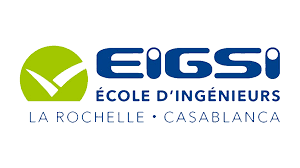


# **This notebook is part of a Machine Learning course project** 
**Par : Ayman Moumen & Marwane limouri**

**Encadreé par : M. Cédric Stéphane KOUMETIO TEKOUABOU**

## TMDB Score Prediction and Movie Recommendation



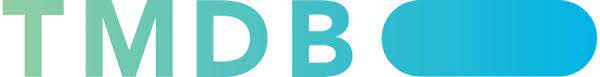

### Les systèmes de recommandation deviennent de plus en plus importants dans le monde trépidant d'aujourd'hui. Les gens sont toujours à la recherche de produits/services qui leur conviennent le mieux. Par conséquent, les systèmes de recommandation sont importants car ils les aident à faire les bons choix, sans avoir à mobiliser leurs ressources cognitives.

### Dans ce noyau, je vais construire un système de recommandation de films en utilisant le filtrage collaboratif en implémentant l'algorithme des K plus proches voisins. Je prédirai également la note du film donné en fonction de ses voisins et la comparerai avec la note réelle.

### Consultez mon [blog](my blog link) pour une meilleure compréhension.

### **Import the required Python libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')
import base64
import io
from matplotlib.pyplot import imread
import codecs
from IPython.display import HTML

### **Import the dataset**

In [ ]:
movies = pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv')
credits = pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_credits.csv')

## **Data Exploration & Cleaning**

In [ ]:
movies.head()

In [ ]:
movies.describe()

In [ ]:
credits.head()

In [ ]:
credits.describe()

**Converting JSON into strings**

In [ ]:
# changing the genres column from json to string
movies['genres'] = movies['genres'].apply(json.loads)
for index,i in zip(movies.index,movies['genres']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name'])) # the key 'name' contains the name of the genre
    movies.loc[index,'genres'] = str(list1)

# changing the keywords column from json to string
movies['keywords'] = movies['keywords'].apply(json.loads)
for index,i in zip(movies.index,movies['keywords']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies.loc[index,'keywords'] = str(list1)
    
# changing the production_companies column from json to string
movies['production_companies'] = movies['production_companies'].apply(json.loads)
for index,i in zip(movies.index,movies['production_companies']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies.loc[index,'production_companies'] = str(list1)

# changing the cast column from json to string
credits['cast'] = credits['cast'].apply(json.loads)
for index,i in zip(credits.index,credits['cast']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    credits.loc[index,'cast'] = str(list1)

# changing the crew column from json to string    
credits['crew'] = credits['crew'].apply(json.loads)
def director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
credits['crew'] = credits['crew'].apply(director)
credits.rename(columns={'crew':'director'},inplace=True)

In [ ]:
movies.head()

In [ ]:
movies.iloc[25]

### **Merging the two csv files**

In [ ]:
movies = movies.merge(credits,left_on='id',right_on='movie_id',how='left')
movies = movies[['id','original_title','genres','cast','vote_average','director','keywords']]

In [ ]:
movies.iloc[25]

In [ ]:
movies.shape

In [ ]:
movies.size

In [ ]:
movies.index

In [ ]:
movies.columns

In [ ]:
movies.dtypes

## **Working with the Genres column**

In [ ]:
movies['genres'] = movies['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['genres'] = movies['genres'].str.split(',')

In [ ]:
plt.subplots(figsize=(12,10))
list1 = []
for i in movies['genres']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Genres')
plt.show()

Drama semble être le genre le plus populaire, suivi de la comédie.

In [ ]:
for i,j in zip(movies['genres'],movies.index):
    list2=[]
    list2=i
    list2.sort()
    movies.loc[j,'genres']=str(list2)
movies['genres'] = movies['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['genres'] = movies['genres'].str.split(',')

Créons maintenant une liste 'genreList' avec tous les genres uniques possibles mentionnés dans l'ensemble de données.

In [ ]:
genreList = []
for index, row in movies.iterrows():
    genres = row["genres"]
    
    for genre in genres:
        if genre not in genreList:
            genreList.append(genre)
genreList[:10] #now we have a list with unique genres

**One Hot Encoding for multiple labels**

In [ ]:
def binary(genre_list):
    binaryList = []
    
    for genre in genreList:
        if genre in genre_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [ ]:
movies['genres_bin'] = movies['genres'].apply(lambda x: binary(x))
movies['genres_bin'].head()

## **Working with the Cast Column**
 

In [ ]:
movies['cast'] = movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies['cast'] = movies['cast'].str.split(',')

In [ ]:
plt.subplots(figsize=(12,10))
list1=[]
for i in movies['cast']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(pd.Series(list1).value_counts()[:15].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='white',weight='bold')
plt.title('Actors with highest appearance')
plt.show()

In [ ]:
for i,j in zip(movies['cast'],movies.index):
    list2 = []
    list2 = i[:4]
    movies.loc[j,'cast'] = str(list2)
movies['cast'] = movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['cast'] = movies['cast'].str.split(',')
for i,j in zip(movies['cast'],movies.index):
    list2 = []
    list2 = i
    list2.sort()
    movies.loc[j,'cast'] = str(list2)
movies['cast']=movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'')

In [ ]:
castList = []
for index, row in movies.iterrows():
    cast = row["cast"]
    
    for i in cast:
        if i not in castList:
            castList.append(i)

In [ ]:
def binary(cast_list):
    binaryList = []
    
    for genre in castList:
        if genre in cast_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [ ]:
movies['cast_bin'] = movies['cast'].apply(lambda x: binary(x))
movies['cast_bin'].head()

## **Working with Director column**

In [ ]:
def xstr(s):
    if s is None:
        return ''
    return str(s)
movies['director'] = movies['director'].apply(xstr)

In [ ]:
plt.subplots(figsize=(12,10))
ax = movies[movies['director']!=''].director.value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(movies[movies['director']!=''].director.value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.5, i, v,fontsize=12,color='white',weight='bold')
plt.title('Directors with highest movies')
plt.show()

In [ ]:
directorList=[]
for i in movies['director']:
    if i not in directorList:
        directorList.append(i)

In [ ]:
def binary(director_list):
    binaryList = []  
    for direct in directorList:
        if direct in director_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList

In [ ]:
movies['director_bin'] = movies['director'].apply(lambda x: binary(x))
movies.head()

## **Working with the Keywords column**

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords

In [ ]:
plt.subplots(figsize=(12,12))
stop_words = set(stopwords.words('english'))
stop_words.update(',',';','!','?','.','(',')','$','#','+',':','...',' ','')

words=movies['keywords'].dropna().apply(nltk.word_tokenize)
word=[]
for i in words:
    word.extend(i)
word=pd.Series(word)
word=([i for i in word.str.lower() if i not in stop_words])
wc = WordCloud(background_color="black", max_words=2000, stopwords=STOPWORDS, max_font_size= 60,width=1000,height=1000)
wc.generate(" ".join(word))
plt.imshow(wc)
plt.axis('off')
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

Ci-dessus se trouve un nuage de mots montrant les principaux mots-clés ou tags utilisés pour décrire les films.


In [ ]:
movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies['keywords'] = movies['keywords'].str.split(',')
for i,j in zip(movies['keywords'],movies.index):
    list2 = []
    list2 = i
    movies.loc[j,'keywords'] = str(list2)
movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['keywords'] = movies['keywords'].str.split(',')
for i,j in zip(movies['keywords'],movies.index):
    list2 = []
    list2 = i
    list2.sort()
    movies.loc[j,'keywords'] = str(list2)
movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['keywords'] = movies['keywords'].str.split(',')

In [ ]:
movies

In [ ]:
words_list = []
for index, row in movies.iterrows():
    genres = row["keywords"]
    
    for genre in genres:
        if genre not in words_list:
            words_list.append(genre)

In [ ]:
def binary(words):
    binaryList = []
    for genre in words_list:
        if genre in words:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList

In [ ]:
movies['words_bin'] = movies['keywords'].apply(lambda x: binary(x))
movies = movies[(movies['vote_average']!=0)] #removing the movies with 0 score and without drector names 
movies = movies[movies['director']!='']

## Similarity between movies

Nous utiliserons la similarité cosinus pour trouver la similarité entre deux films.

In [ ]:
from scipy import spatial

def Similarity(movieId1, movieId2):
    a = movies.iloc[movieId1]
    b = movies.iloc[movieId2]
    
    genresA = a['genres_bin']
    genresB = b['genres_bin']
    
    genreDistance = spatial.distance.cosine(genresA, genresB)
    
    scoreA = a['cast_bin']
    scoreB = b['cast_bin']
    scoreDistance = spatial.distance.cosine(scoreA, scoreB)
    
    directA = a['director_bin']
    directB = b['director_bin']
    directDistance = spatial.distance.cosine(directA, directB)
    
    wordsA = a['words_bin']
    wordsB = b['words_bin']
    wordsDistance = spatial.distance.cosine(directA, directB)
    return genreDistance + directDistance + scoreDistance + wordsDistance

In [ ]:
Similarity(3,160) #checking similarity between any 2 random movies

Nous constatons que la distance est d'environ 2,068, ce qui est élevé. Plus la distance est grande, moins les films sont similaires. Voyons maintenant de quels films aléatoires il s'agissait réellement.

In [ ]:
print(movies.iloc[3])
print(movies.iloc[160])

Il est évident que "The Dark Knight Rises" et "How to Train Your Dragon 2" sont des films très différents. Ainsi, la distance entre eux est énorme.

In [ ]:
new_id = list(range(0,movies.shape[0]))
movies['new_id']=new_id
movies=movies[['original_title','genres','vote_average','genres_bin','cast_bin','new_id','director','director_bin','words_bin']]
movies.head()

## **Score Predictor**

In [ ]:
import operator

def predict_score(name):
    #name = input('Enter a movie title: ')
    new_movie = movies[movies['original_title'].str.contains(name)].iloc[0].to_frame().T
    print('Selected Movie: ',new_movie.original_title.values[0])
    def getNeighbors(baseMovie, K):
        distances = []
    
        for index, movie in movies.iterrows():
            if movie['new_id'] != baseMovie['new_id'].values[0]:
                dist = Similarity(baseMovie['new_id'].values[0], movie['new_id'])
                distances.append((movie['new_id'], dist))
    
        distances.sort(key=operator.itemgetter(1))
        neighbors = []
    
        for x in range(K):
            neighbors.append(distances[x])
        return neighbors

    K = 10
    avgRating = 0
    neighbors = getNeighbors(new_movie, K)
    
    print('\nRecommended Movies: \n')
    for neighbor in neighbors:
        avgRating = avgRating+movies.iloc[neighbor[0]][2]  
        print( movies.iloc[neighbor[0]][0]+" | Genres: "+str(movies.iloc[neighbor[0]][1]).strip('[]').replace(' ','')+" | Rating: "+str(movies.iloc[neighbor[0]][2]))
    
    print('\n')
    avgRating = avgRating/K
    print('The predicted rating for %s is: %f' %(new_movie['original_title'].values[0],avgRating))
    print('The actual rating for %s is %f' %(new_movie['original_title'].values[0],new_movie['vote_average']))

In [ ]:
predict_score('Godfather')

In [ ]:
predict_score('Donnie Darko')

In [ ]:
predict_score('Notting Hill')

In [ ]:
predict_score('Despicable Me')

In [ ]:
#predict_score()

### Ainsi, nous avons terminé la mise en œuvre du système de recommandation de films en utilisant l'algorithme Knn: K Nearest Neighbors algorithm.